# 인공지능과 가위바위보 하기

|평가문항|상세기준|
|---|---|
|1. 이미지 분류기 모델이 성공적으로 만들어졌는가?|학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음|
|2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?|오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음|
|3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?|60% 이상 도달하였음|

In [577]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import os
import random
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from PIL import Image
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [578]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

데이터는 직접준비한 이미지 300장과 다른사람으로부터 받은 이미지 1530장을 합하여 총 1830장의 이미지를 사용한다.  
이때 다른사람으로부터 받은 이미지중 300장을 test set으로 할당하고 나머지 1530장의 이미지만을 이용해서 학습을 진행한다.

In [579]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getcwd() + "/scissor"
resize_images(image_dir_path)
image_dir_path = os.getcwd() + "/rock"
resize_images(image_dir_path)
image_dir_path = os.getcwd() + "/paper"
resize_images(image_dir_path)

510  images to be resized.


C:\Users\gibeom\AppData\Local\Temp\ipykernel_8180\1816252219.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


510  images resized.
510  images to be resized.
510  images resized.
510  images to be resized.
510  images resized.


In [580]:
def load_data(img_path, number_of_data=1530):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getcwd()
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 1530 입니다.
x_train shape: (1530, 28, 28, 3)
y_train shape: (1530,)


라벨:  0


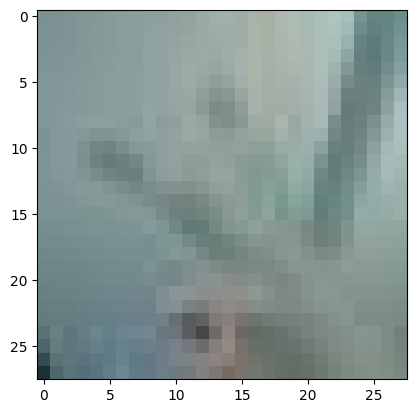

In [581]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [582]:
image_dir_path = os.getcwd() + "/test/scissor"
resize_images(image_dir_path)
image_dir_path = os.getcwd() + "/test/rock"
resize_images(image_dir_path)
image_dir_path = os.getcwd() + "/test/paper"
resize_images(image_dir_path)

image_dir_path = os.getcwd() + "/test"
(x_test, y_test)=load_data(image_dir_path,number_of_data=300)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100

C:\Users\gibeom\AppData\Local\Temp\ipykernel_8180\1816252219.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


모델을 만들고 어떠한 파라미터가 가장 좋을지 알아내기 위하여 그리드서치를 실시한다.  
또한 데이터의 과적합을 막기 위하여 dropout, 배치 정규화, kfold를 추가로 실시하여 모델을 만들도록 한다.

In [583]:
def create_model(optimizer='adam',dropout_rate=0.2):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(16, (3,3), kernel_regularizer=keras.regularizers.l2(0.01), activation='leaky_relu', input_shape=(28,28,3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2D(32, (2,2), kernel_regularizer=keras.regularizers.l2(0.01), activation='leaky_relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Conv2D(64, (3,3), kernel_regularizer=keras.regularizers.l2(0.01), activation='leaky_relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='leaky_relu'))
    model.add(keras.layers.Dense(16, activation='leaky_relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model)

optimizers = ['rmsprop', 'adam']
epochs = [5,10,20]
dropout_rates=[0.2,0.3]
param_grid = dict(optimizer=optimizers, epochs=epochs, dropout_rate=dropout_rates)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(x_train_norm, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/5


C:\Users\gibeom\AppData\Local\Temp\ipykernel_8180\707732880.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


39/39 [==============================] - 1s 7ms/step - loss: 1.2889 - accuracy: 0.7361
Epoch 2/5
39/39 [==============================] - 0s 7ms/step - loss: 0.8411 - accuracy: 0.9175
Epoch 3/5
39/39 [==============================] - 0s 7ms/step - loss: 0.6945 - accuracy: 0.9518
Epoch 4/5
39/39 [==============================] - 0s 7ms/step - loss: 0.5515 - accuracy: 0.9845
Epoch 5/5
39/39 [==============================] - 0s 7ms/step - loss: 0.4749 - accuracy: 0.9869
Epoch 1/5


C:\Users\gibeom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gibeom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gibeom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\gibeom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\kera

39/39 [==============================] - 1s 7ms/step - loss: 1.2726 - accuracy: 0.7663
Epoch 2/5
39/39 [==============================] - 0s 7ms/step - loss: 0.8521 - accuracy: 0.9224
Epoch 3/5
39/39 [==============================] - 0s 8ms/step - loss: 0.6871 - accuracy: 0.9624
Epoch 4/5
39/39 [==============================] - 0s 8ms/step - loss: 0.5665 - accuracy: 0.9828
Epoch 5/5
39/39 [==============================] - 0s 7ms/step - loss: 0.5036 - accuracy: 0.9828
Epoch 1/5


C:\Users\gibeom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gibeom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gibeom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\gibeom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\kera

39/39 [==============================] - 1s 7ms/step - loss: 1.2706 - accuracy: 0.7704
Epoch 2/5
39/39 [==============================] - 0s 8ms/step - loss: 0.8669 - accuracy: 0.9109
Epoch 3/5
39/39 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.9592
Epoch 4/5
39/39 [==============================] - 0s 8ms/step - loss: 0.5841 - accuracy: 0.9779
Epoch 5/5
39/39 [==============================] - 0s 7ms/step - loss: 0.5120 - accuracy: 0.9845
Epoch 1/5
39/39 [==============================] - 1s 7ms/step - loss: 1.3706 - accuracy: 0.6961
Epoch 2/5
39/39 [==============================] - 0s 7ms/step - loss: 0.9036 - accuracy: 0.9232
Epoch 3/5
39/39 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.9665
Epoch 4/5
39/39 [==============================] - 0s 7ms/step - loss: 0.6159 - accuracy: 0.9698
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: 3.4808 - accuracy: 0.0000e+00
Epoch 1/5
39/39 [===================

C:\Users\gibeom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


48/48 [==============================] - 1s 7ms/step - loss: 1.2790 - accuracy: 0.7438
Epoch 2/5
48/48 [==============================] - 0s 7ms/step - loss: 0.8193 - accuracy: 0.9242
Epoch 3/5
48/48 [==============================] - 0s 8ms/step - loss: 0.6469 - accuracy: 0.9680
Epoch 4/5
48/48 [==============================] - 0s 8ms/step - loss: 0.5364 - accuracy: 0.9817
Epoch 5/5
48/48 [==============================] - 0s 8ms/step - loss: 0.4802 - accuracy: 0.9843
Best: nan using {'dropout_rate': 0.2, 'epochs': 5, 'optimizer': 'rmsprop'}


그리드서치 결과 'dropout_rate': 0.2, 'epochs': 5, 'optimizer': 'rmsprop'가 가장 좋은 결과를 보였으므로 해당 파라미터를 이용하여 학습을 진행하도록 한다.

In [857]:
# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='leaky_relu', input_shape=(28,28,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (2,2), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='leaky_relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, (3,3), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='leaky_relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='leaky_relu'))
model.add(keras.layers.Dense(16, activation='leaky_relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_574"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1710 (Conv2D)        (None, 26, 26, 16)        448       
                                                                 
 batch_normalization_1706 (B  (None, 26, 26, 16)       64        
 atchNormalization)                                              
                                                                 
 max_pooling2d_1710 (MaxPool  (None, 13, 13, 16)       0         
 ing2D)                                                          
                                                                 
 conv2d_1711 (Conv2D)        (None, 12, 12, 32)        2080      
                                                                 
 batch_normalization_1707 (B  (None, 12, 12, 32)       128       
 atchNormalization)                                              
                                                    

In [858]:
k = 10
kfold = KFold(n_splits = k)
train_loss = []
test_loss =[]
acc=[]
test_acc=[]

model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'],)

for train_index, val_index in kfold.split(x_train_norm) :
    x_train_fold, x_val_fold = x_train_norm[train_index], x_train_norm[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    hist=model.fit(x_train_fold, y_train_fold, epochs = 5, validation_data = (x_test_norm, y_test))
    test_loss.append(hist.history['val_loss'])
    train_loss.append(hist.history['loss'])
    acc.append(hist.history['accuracy'])
    test_acc.append(hist.history['val_accuracy'])

Epoch 1/5
44/44 [==============================] - 1s 11ms/step - loss: 1.2987 - accuracy: 0.7567 - val_loss: 1.7383 - val_accuracy: 0.3900
Epoch 2/5
44/44 [==============================] - 0s 8ms/step - loss: 0.8260 - accuracy: 0.9375 - val_loss: 1.6934 - val_accuracy: 0.3400
Epoch 3/5
44/44 [==============================] - 0s 8ms/step - loss: 0.6799 - accuracy: 0.9615 - val_loss: 1.6603 - val_accuracy: 0.3567
Epoch 4/5
44/44 [==============================] - 0s 8ms/step - loss: 0.5866 - accuracy: 0.9804 - val_loss: 1.6296 - val_accuracy: 0.3433
Epoch 5/5
44/44 [==============================] - 0s 8ms/step - loss: 0.5133 - accuracy: 0.9877 - val_loss: 1.7164 - val_accuracy: 0.3400
Epoch 1/5
44/44 [==============================] - 0s 8ms/step - loss: 0.5325 - accuracy: 0.9680 - val_loss: 1.7034 - val_accuracy: 0.3300
Epoch 2/5
44/44 [==============================] - 0s 8ms/step - loss: 0.4265 - accuracy: 0.9898 - val_loss: 1.9315 - val_accuracy: 0.3667
Epoch 3/5
44/44 [=========

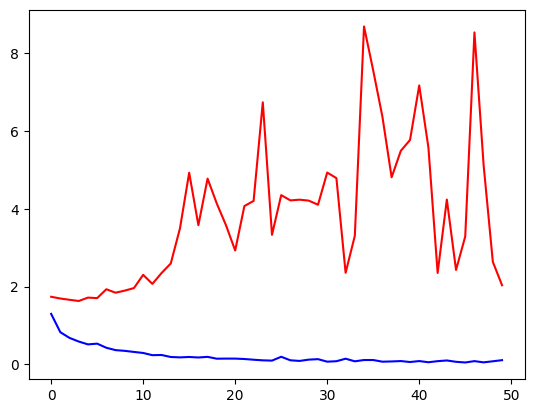

In [859]:
train_loss=np.array(train_loss)
test_loss=np.array(test_loss)
train_loss=train_loss.reshape(train_loss.shape[0]*train_loss.shape[1],1)
test_loss=test_loss.reshape(test_loss.shape[0]*test_loss.shape[1],1)
plt.plot(train_loss,color="blue")
plt.plot(test_loss,color="red")

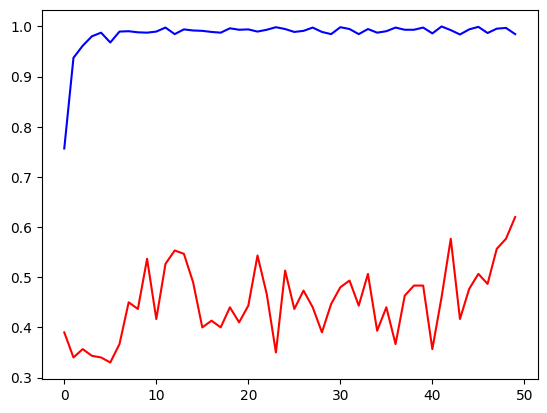

In [860]:
acc=np.array(acc)
test_acc=np.array(test_acc)
acc=acc.reshape(acc.shape[0]*acc.shape[1],1)
test_acc=test_acc.reshape(test_acc.shape[0]*test_acc.shape[1],1)
plt.plot(acc,color="blue")
plt.plot(test_acc,color="red")

In [861]:
y_predict=model.predict(x_test_norm)
y_predict

10/10 [==============================] - 0s 2ms/step


array([[9.69903078e-04, 1.36156945e-04, 9.98893917e-01],
       [3.57964635e-03, 6.25790999e-05, 9.96357739e-01],
       [9.11154747e-01, 1.30075627e-04, 8.87151733e-02],
       [9.93441820e-01, 1.22552171e-06, 6.55696914e-03],
       [9.91904318e-01, 9.94039510e-07, 8.09480995e-03],
       [9.91904318e-01, 9.94039510e-07, 8.09480995e-03],
       [9.99912262e-01, 1.04449566e-06, 8.66939445e-05],
       [9.99460399e-01, 2.50151661e-05, 5.14596817e-04],
       [9.95161474e-01, 9.15974124e-06, 4.82935226e-03],
       [9.99971509e-01, 4.03874871e-08, 2.84916005e-05],
       [9.98754978e-01, 3.88171111e-06, 1.24108896e-03],
       [9.49489951e-01, 9.27724905e-05, 5.04172556e-02],
       [1.62413772e-02, 4.54884903e-05, 9.83713150e-01],
       [3.10325027e-01, 5.24171992e-05, 6.89622521e-01],
       [4.34460253e-01, 7.79178168e-04, 5.64760566e-01],
       [3.20615582e-02, 6.15705940e-05, 9.67876852e-01],
       [3.43545750e-02, 4.95649692e-05, 9.65595841e-01],
       [2.33631227e-02, 5.06244

In [862]:
def get_answer(arr):
    ans=[]
    for i in range(len(arr)):
        ans.append(arr[i].argmax())
        
    return ans

mod_y_predict=get_answer(y_predict)
accuracy_score(y_test,mod_y_predict)

0.62

학습을 실시한 결과, test_loss와 test_acc의 그래프를 보게되면 학습을 진행함에 따라서 점점 test_loss가 발산하는 것을 볼 수 있다.  
그리고 그에 따라서 test_acc도 발산하는 모습을 보이는데 learning rate가 너무 큰 탓인가 하는 생각을 하여 테스트를 실시하였다.

In [865]:
# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='leaky_relu', input_shape=(28,28,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (2,2), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='leaky_relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, (3,3), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='leaky_relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='leaky_relu'))
model.add(keras.layers.Dense(16, activation='leaky_relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_576"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1716 (Conv2D)        (None, 26, 26, 16)        448       
                                                                 
 batch_normalization_1712 (B  (None, 26, 26, 16)       64        
 atchNormalization)                                              
                                                                 
 max_pooling2d_1716 (MaxPool  (None, 13, 13, 16)       0         
 ing2D)                                                          
                                                                 
 conv2d_1717 (Conv2D)        (None, 12, 12, 32)        2080      
                                                                 
 batch_normalization_1713 (B  (None, 12, 12, 32)       128       
 atchNormalization)                                              
                                                    

In [866]:
k = 10
kfold = KFold(n_splits = k)
train_loss = []
test_loss =[]
acc=[]
test_acc=[]

from tensorflow.keras.optimizers.experimental import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'],)

for train_index, val_index in kfold.split(x_train_norm) :
    x_train_fold, x_val_fold = x_train_norm[train_index], x_train_norm[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    hist=model.fit(x_train_fold, y_train_fold, epochs = 5, validation_data = (x_test_norm, y_test))
    test_loss.append(hist.history['val_loss'])
    train_loss.append(hist.history['loss'])
    acc.append(hist.history['accuracy'])
    test_acc.append(hist.history['val_accuracy'])

Epoch 1/5
44/44 [==============================] - 1s 11ms/step - loss: 1.7390 - accuracy: 0.4924 - val_loss: 1.7840 - val_accuracy: 0.3333
Epoch 2/5
44/44 [==============================] - 0s 7ms/step - loss: 1.4521 - accuracy: 0.6747 - val_loss: 1.7816 - val_accuracy: 0.3333
Epoch 3/5
44/44 [==============================] - 0s 7ms/step - loss: 1.3049 - accuracy: 0.7545 - val_loss: 1.7788 - val_accuracy: 0.3333
Epoch 4/5
44/44 [==============================] - 0s 8ms/step - loss: 1.1861 - accuracy: 0.8221 - val_loss: 1.7679 - val_accuracy: 0.4133
Epoch 5/5
44/44 [==============================] - 0s 7ms/step - loss: 1.0928 - accuracy: 0.8686 - val_loss: 1.7618 - val_accuracy: 0.4533
Epoch 1/5
44/44 [==============================] - 0s 8ms/step - loss: 1.1171 - accuracy: 0.8359 - val_loss: 1.7249 - val_accuracy: 0.4800
Epoch 2/5
44/44 [==============================] - 0s 7ms/step - loss: 1.0072 - accuracy: 0.8969 - val_loss: 1.7018 - val_accuracy: 0.4600
Epoch 3/5
44/44 [=========

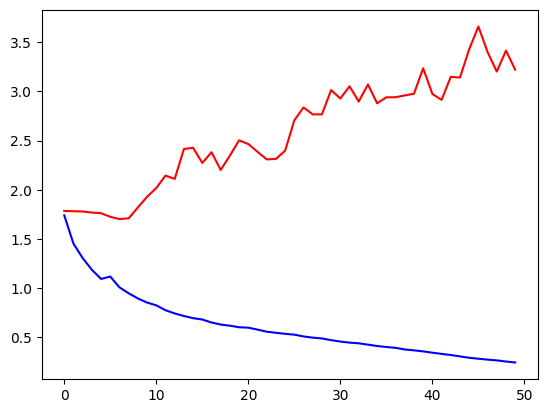

In [867]:
train_loss=np.array(train_loss)
test_loss=np.array(test_loss)
train_loss=train_loss.reshape(train_loss.shape[0]*train_loss.shape[1],1)
test_loss=test_loss.reshape(test_loss.shape[0]*test_loss.shape[1],1)
plt.plot(train_loss,color="blue")
plt.plot(test_loss,color="red")

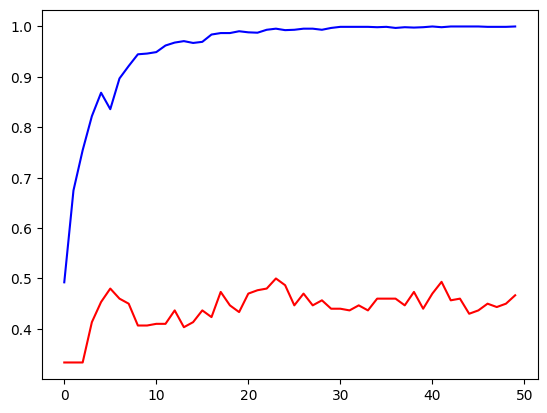

In [868]:
acc=np.array(acc)
test_acc=np.array(test_acc)
acc=acc.reshape(acc.shape[0]*acc.shape[1],1)
test_acc=test_acc.reshape(test_acc.shape[0]*test_acc.shape[1],1)
plt.plot(acc,color="blue")
plt.plot(test_acc,color="red")

In [878]:
# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='leaky_relu', input_shape=(28,28,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (2,2), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='leaky_relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, (3,3), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='leaky_relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='leaky_relu'))
model.add(keras.layers.Dense(16, activation='leaky_relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_579"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1725 (Conv2D)        (None, 26, 26, 16)        448       
                                                                 
 batch_normalization_1721 (B  (None, 26, 26, 16)       64        
 atchNormalization)                                              
                                                                 
 max_pooling2d_1725 (MaxPool  (None, 13, 13, 16)       0         
 ing2D)                                                          
                                                                 
 conv2d_1726 (Conv2D)        (None, 12, 12, 32)        2080      
                                                                 
 batch_normalization_1722 (B  (None, 12, 12, 32)       128       
 atchNormalization)                                              
                                                    

In [879]:
k = 10
kfold = KFold(n_splits = k)
train_loss = []
test_loss =[]
acc=[]
test_acc=[]

from tensorflow.keras.optimizers.experimental import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.00001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'],)

for train_index, val_index in kfold.split(x_train_norm) :
    x_train_fold, x_val_fold = x_train_norm[train_index], x_train_norm[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    hist=model.fit(x_train_fold, y_train_fold, epochs = 20, validation_data = (x_test_norm, y_test))
    test_loss.append(hist.history['val_loss'])
    train_loss.append(hist.history['loss'])
    acc.append(hist.history['accuracy'])
    test_acc.append(hist.history['val_accuracy'])

Epoch 1/20
44/44 [==============================] - 1s 12ms/step - loss: 2.2010 - accuracy: 0.3130 - val_loss: 1.8187 - val_accuracy: 0.3333
Epoch 2/20
44/44 [==============================] - 0s 8ms/step - loss: 2.0270 - accuracy: 0.3435 - val_loss: 1.8836 - val_accuracy: 0.3333
Epoch 3/20
44/44 [==============================] - 0s 9ms/step - loss: 1.9101 - accuracy: 0.3791 - val_loss: 1.9497 - val_accuracy: 0.3333
Epoch 4/20
44/44 [==============================] - 0s 8ms/step - loss: 1.8319 - accuracy: 0.4096 - val_loss: 1.9944 - val_accuracy: 0.3367
Epoch 5/20
44/44 [==============================] - 0s 8ms/step - loss: 1.7691 - accuracy: 0.4553 - val_loss: 2.0110 - val_accuracy: 0.4533
Epoch 6/20
44/44 [==============================] - 0s 8ms/step - loss: 1.7042 - accuracy: 0.5033 - val_loss: 2.0010 - val_accuracy: 0.4900
Epoch 7/20
44/44 [==============================] - 0s 8ms/step - loss: 1.6650 - accuracy: 0.5309 - val_loss: 1.9835 - val_accuracy: 0.4267
Epoch 8/20
44/44 [=

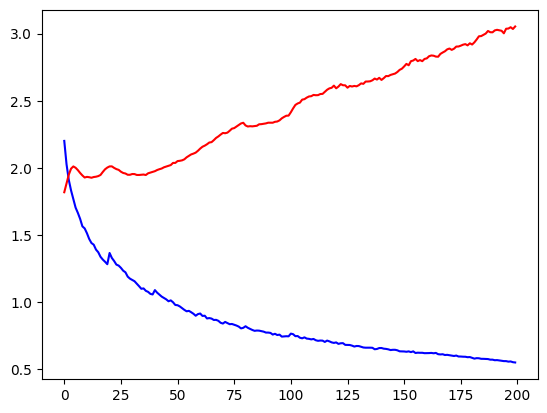

In [880]:
train_loss=np.array(train_loss)
test_loss=np.array(test_loss)
train_loss=train_loss.reshape(train_loss.shape[0]*train_loss.shape[1],1)
test_loss=test_loss.reshape(test_loss.shape[0]*test_loss.shape[1],1)
plt.plot(train_loss,color="blue")
plt.plot(test_loss,color="red")

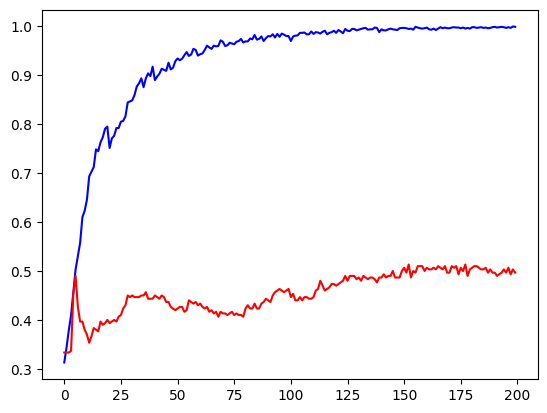

In [881]:
acc=np.array(acc)
test_acc=np.array(test_acc)
acc=acc.reshape(acc.shape[0]*acc.shape[1],1)
test_acc=test_acc.reshape(test_acc.shape[0]*test_acc.shape[1],1)
plt.plot(acc,color="blue")
plt.plot(test_acc,color="red")

learning rate를 줄이고 epoch 수를 늘려서 테스트를 해보았지만 결국 발산을 하는 경향 자체는 계속해서 나타나는 것을 알 수 있다.  
결국 과적합이 발생하고 있다는 것을 의미하는데, 그럼에도 불구하고 validation data에 대한 score자체는 점점 증가하는 경향을 보임을 알 수있다.  
마지막 모델의 경우 총 epoch 수가 200으로 너무 많은 학습을 진행하여 과적합이 되는게 맞지만 test_loss의 그래프 자체가 처음부터 점점 증가하는 우상향의 그래프를 그리는 것을 알 수 있다.  
처음부터 loss가 증가하는 경향을 나타내는 이유에 대해서는 여러모로 알아보았으나 정확한 이유는 알기가 어려웠다.

이점에 대해서는 좀더 검색하고 공부하는 것이 필요할 것으로 생각된다.